<a href="https://www.kaggle.com/code/iwways/backpack-eda-model-tuning?scriptVersionId=220263852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1️⃣ Introduction

## 🏆 Overview of the competition

In this playground competition we should predict backpack price based on different features, such as weight capacity, brand, material, size, compartments,  laptop compartment, waterproof, style and color.

## 🎯 Problem statement & objectives

Backpacks are an essential part of everyday life for many people, especially in modern times when individuals carry a wide variety of personal and professional items daily. Whether it’s for work, school, travel, or outdoor activities, backpacks provide the convenience of carrying everything needed for the day. One group that particularly benefits from this versatility is programmers, who often need to carry a range of equipment, from laptops and chargers to notebooks and headphones, all essential to their daily tasks.

This is where our challenge lies: using machine learning to predict key features of backpacks based on their characteristics. The goal is not just to create a predictive model, but to better understand the dataset, create meaningful insights, and ultimately fine-tune our model to predict with greater accuracy 📈.

Our objectives for this notebook are:
* 📊 Exploratory Data Analysis (EDA): Conduct a thorough analysis of the dataset to uncover insights about how different features correlate with each other and the target variable 🔍
* 🚀 Baseline Model: Establish a simple baseline model to set performance expectations and identify room for improvement 🧑‍💻
* 🛠️Feature Engineering: Identify and create new features that may enhance model performance and better represent the data 💡
* 🎛️ Hyperparameter Tuning: Optimize model performance by adjusting hyperparameters using Optuna to find the most effective configuration ⚙️
* 📈 Model Evaluation: Assess the performance of the model using various metrics and discuss potential improvements moving forward 🎯
Through this journey, we’ll focus on not only building a model but also enhancing our understanding of the data, ensuring that we leverage the best techniques to achieve high predictive accuracy. 💪

# 2️⃣ Exploratory Data Analysis (EDA)

## 📊 Data overview (shape, missing values, types)

Let's take a look on training data.

In [2]:
X_train = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
X_test = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
sample_subm = pd.read_csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')

From first look we're having a small number of columns with categorical and numerical features.

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


Good, we're have 300k rows and 11 columns in dataset. What about missing values?

In [4]:
X_train.isna().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

We're having missing values in all columns, except for id, compartments and price. The biggest number of missing values in color and brand column. Is the same thing in test data?

In [5]:
X_test.isna().sum()

id                         0
Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

Yep, the same thing goes here. Now let's take a look on descriptive statistics.

In [6]:
X_train.describe(include='all')

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
count,300000.000000,290295,291653,293405,300000.000000,292556,292950,292030,290050,299862.000000,300000.000000
unique,NaN,5,4,3,NaN,2,2,3,6,NaN,NaN
top,NaN,Adidas,Polyester,Medium,NaN,Yes,Yes,Messenger,Pink,NaN,NaN
freq,NaN,60077,79630,101906,NaN,148342,148077,100031,51690,NaN,NaN
mean,149999.500000,NaN,NaN,NaN,5.443590,NaN,NaN,NaN,NaN,18.029994,81.411107
std,86602.684716,NaN,NaN,NaN,2.890766,NaN,NaN,NaN,NaN,6.966914,39.039340
min,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,5.000000,15.000000
25%,74999.750000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,12.097867,47.384620
50%,149999.500000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,18.068614,80.956120
75%,224999.250000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,24.002375,115.018160


## 📈 Visualizing class distributions

Now let's vizualize our class distributions. Starting from numerical features.

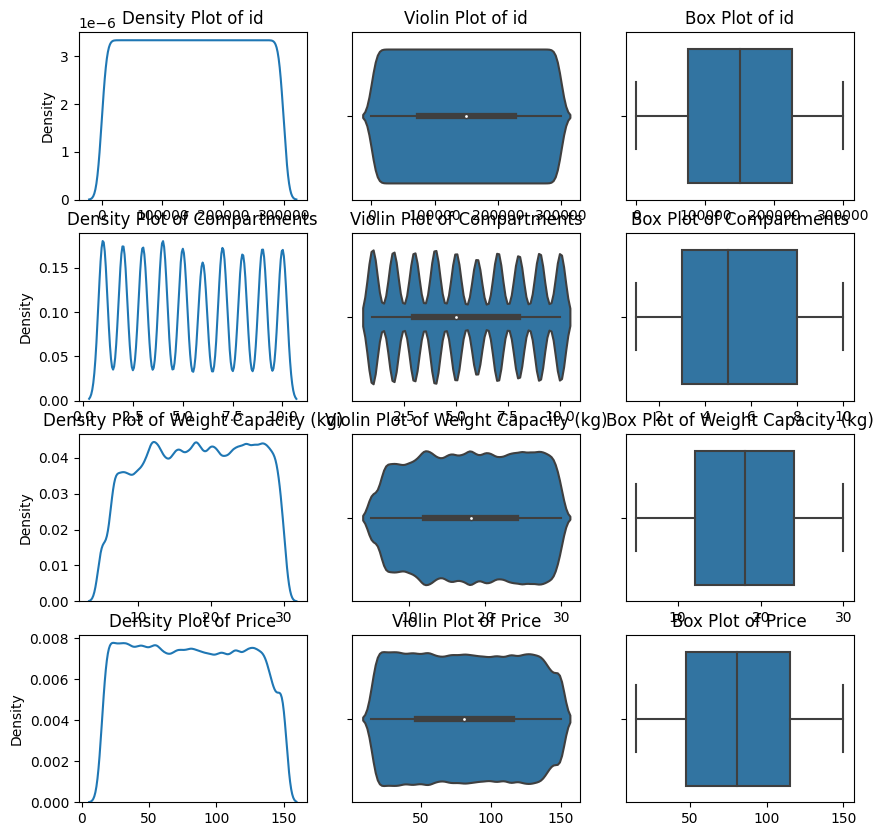

In [7]:
fig, axs = plt.subplots(4,3, figsize=(10,10))
numerical_features = X_train.select_dtypes(exclude='object').columns
r = 0
for feat in numerical_features:
    c = 0
    while c<3:
        if c == 0:
            sns.kdeplot(ax=axs[r, c], data=X_train, x=feat)
            axs[r,c].set_title(f'Density Plot of {feat}')
            axs[r,c].set(xlabel=None)
        elif c == 1:
            sns.violinplot(ax=axs[r,c], data=X_train, x=feat)
            axs[r,c].set_title(f'Violin Plot of {feat}')
            axs[r,c].set(xlabel=None)
        elif c == 2:
            sns.boxplot(ax=axs[r,c], data=X_train, x=feat)
            axs[r,c].set_title(f'Box Plot of {feat}')
            axs[r,c].set(xlabel=None)
        c += 1
    r += 1

And now categorical features.

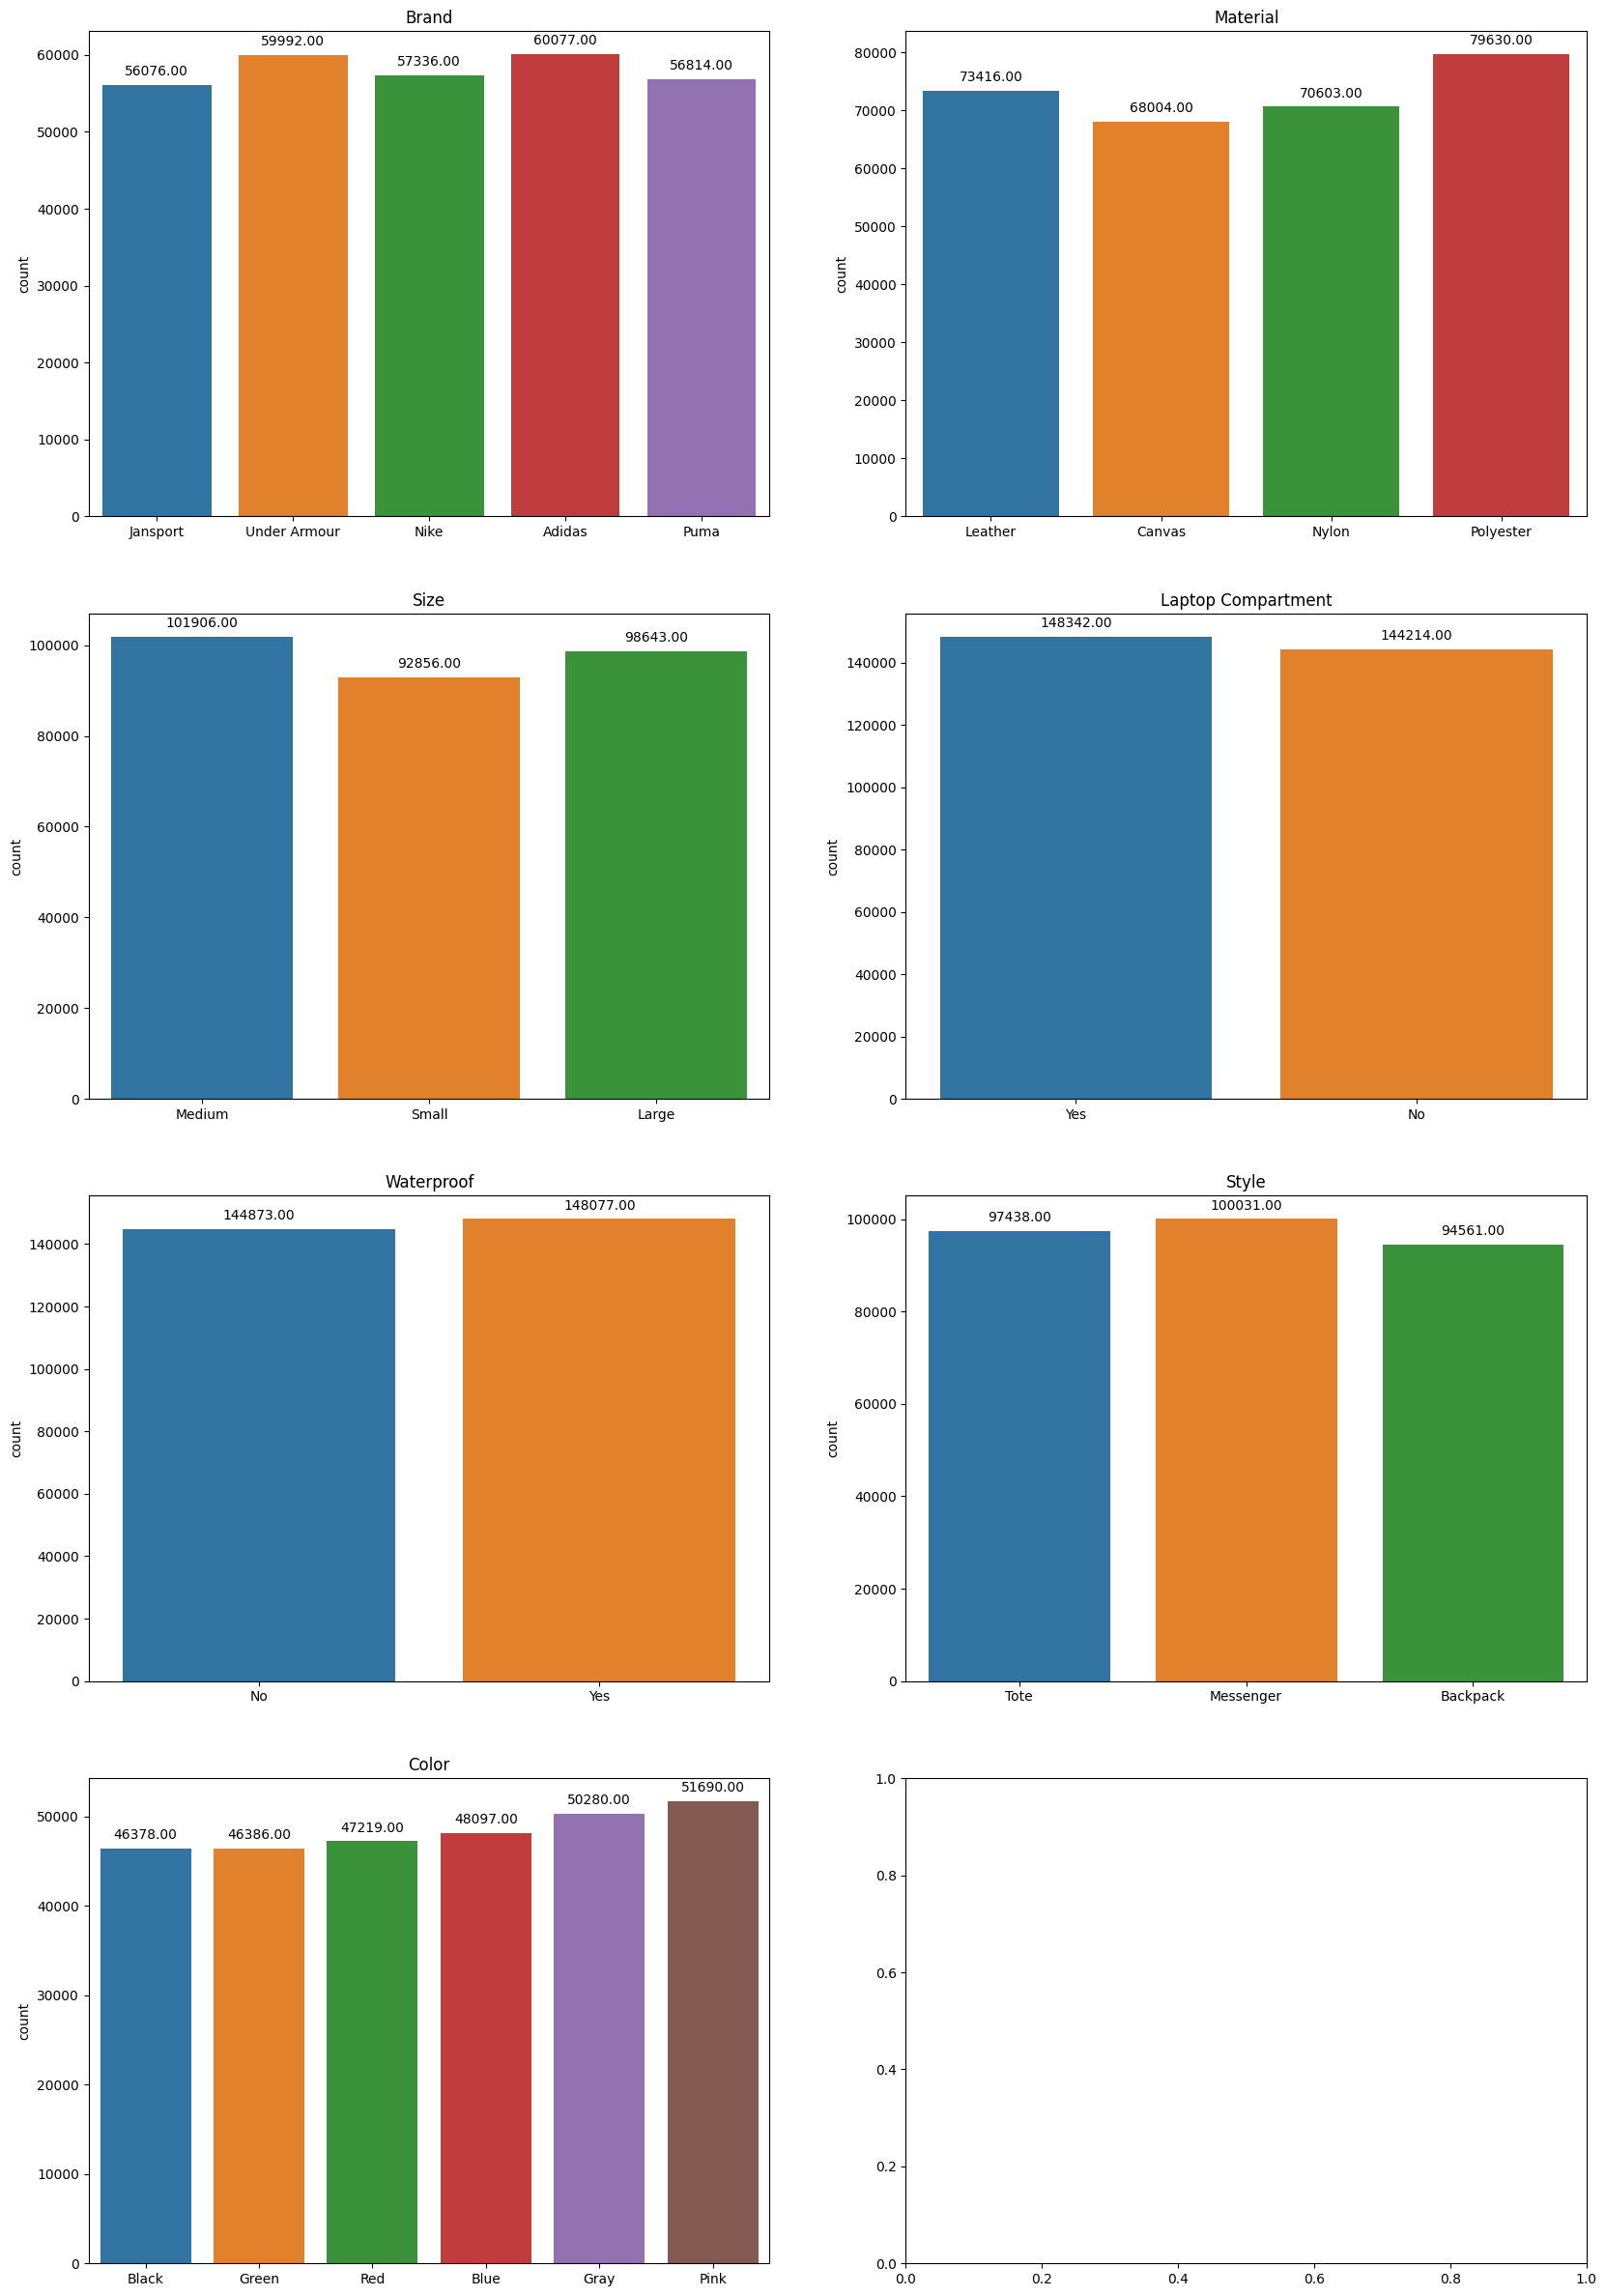

In [8]:
fig, axs = plt.subplots(4,2, figsize=(20,30))
cat_features = X_train.select_dtypes(include='object').columns
r = 0
c = 0
for feat in cat_features:
    if c == 2:
        c = 0
        r += 1
    counts = sns.countplot(ax=axs[r,c], data=X_train, x=feat)
    for p in counts.patches:
        counts.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    axs[r,c].set_title(f'{feat}')
    axs[r,c].set(xlabel=None)

  
    c += 1

Our features seems to be more or less equally distributed across categories.

## 🔬 Feature correlations & relationships

In this section we'll look at correlation between our features and build graphs features VS price.

<Axes: >

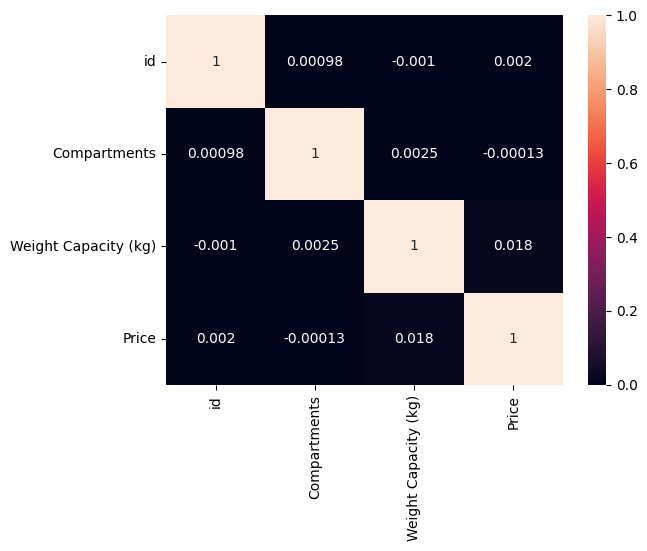

In [9]:
sns.heatmap(X_train[numerical_features].corr(), annot=True)

Our features doesn't have any correlation.

Now let's take a look on features vs target.

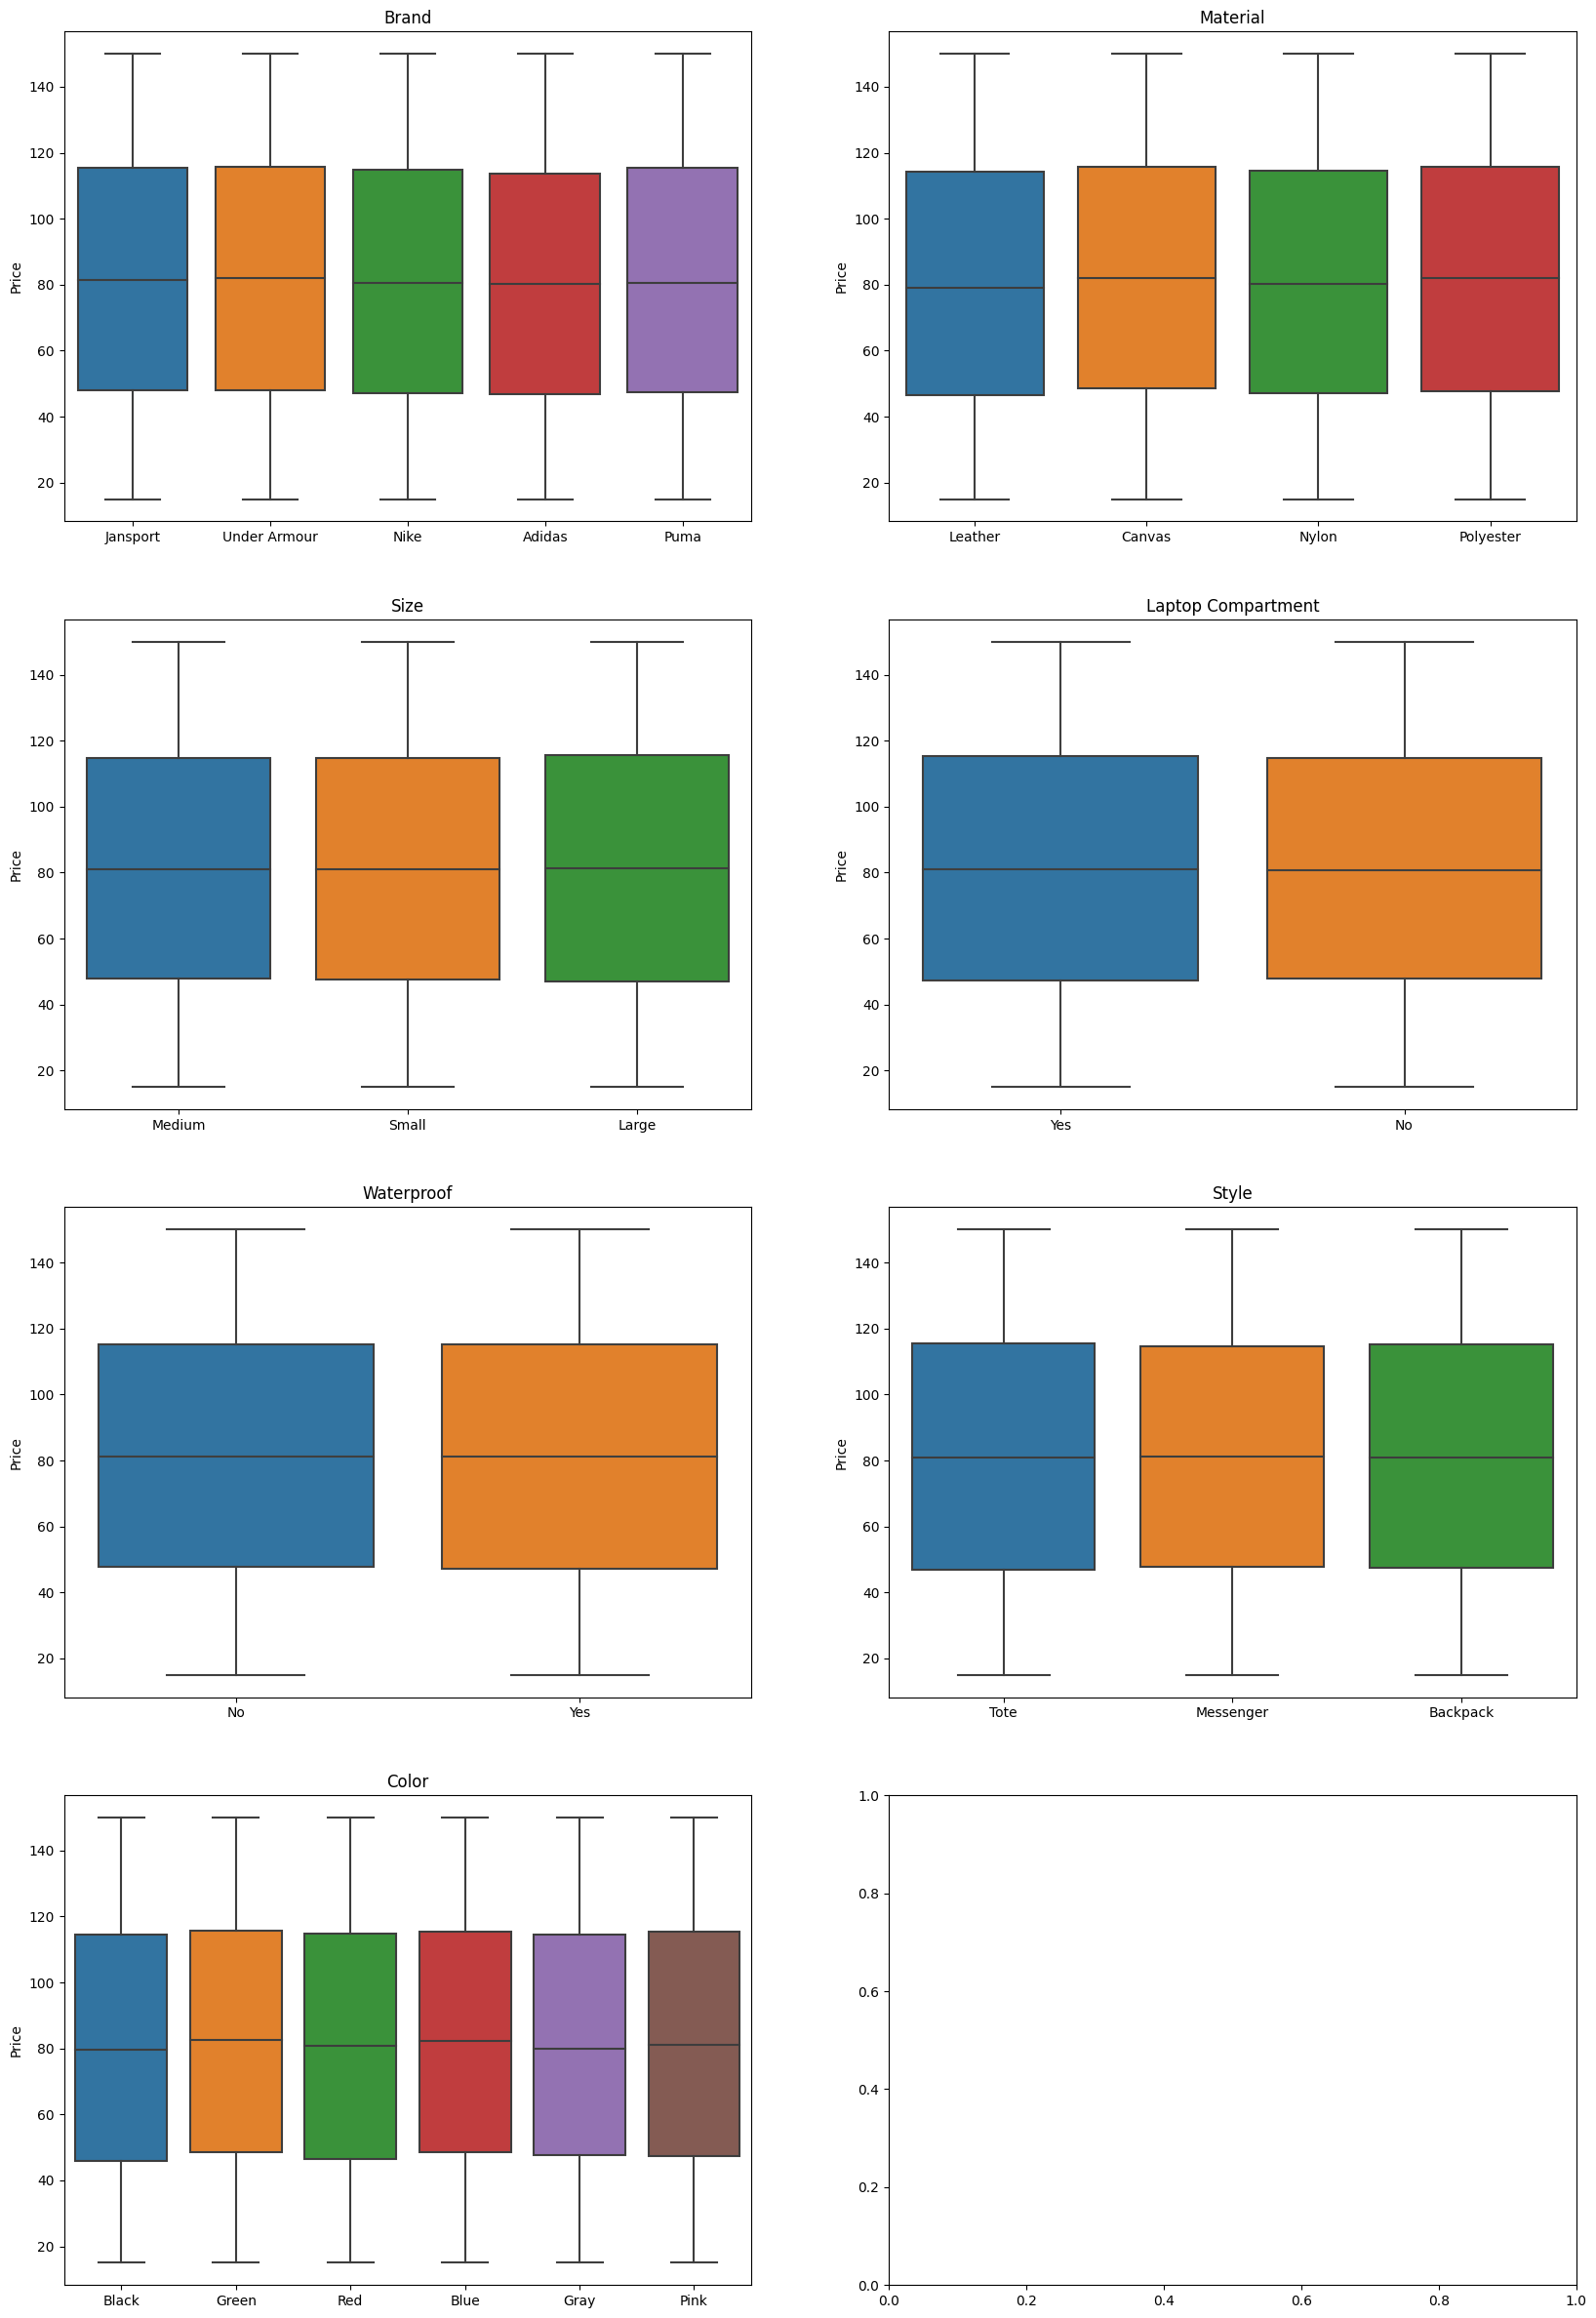

In [10]:
fig, axs = plt.subplots(4,2, figsize=(20,30))
cat_features = X_train.select_dtypes(include='object').columns
r = 0
c = 0
for feat in cat_features:
    if c == 2:
        c = 0
        r += 1
    counts = sns.boxplot(ax=axs[r,c], data=X_train, x=feat, y='Price')
    
    axs[r,c].set_title(f'{feat}')
    axs[r,c].set(xlabel=None)

  
    c += 1

## 💻 Conclusions

From our EDA we can draw the next conclusions:
* The most popular brand is Adidas;
* The most popular material is Polyester;
* The most popular size is Medium;
* On average, backpacks have 5 compartments;
* Laptop Compartment is the most crucial thing in a backpack;
* Waterproof is also crucial, which is logical for keeping laptops and other important things safe (like money);
* Messenger backpacks are the most popular option for style;
* Preferred color is Pink;
* Average weight capacity is 18 kg;
* Average price is 81$.

After exploring distributions and relationships between our features, we can conclude the following:

* Features don't have any correlation;
* Categorical features are equally distributed among categories;
* Price is also equally distributed among different categories.
  
These insights suggest that our dataset maintains a balanced spread, which is promising for further modeling and analysis.

# 3️⃣ Feature Engineering 🏗️

Stay tuned...